In [1]:
"""
PHASE 1 — Setup & Logging + Save Manager
- Creates project directories
- Initializes logging with color + rotating files
- Adds SaveManager utility to handle saving artifacts consistently
"""

from __future__ import annotations
import sys, os, logging, platform, pickle, json
from logging.handlers import RotatingFileHandler
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt

# === Project Paths ===
BASE_DIR = Path.cwd()
DATA_PATH = BASE_DIR / "data" / "liver_cirrhosis.csv"
CLEAN_DATA_PATH = BASE_DIR / "dataset" / "liver_cirrhosis_clean.csv"
PLOTS_DIR = BASE_DIR / "plots"
OUTPUTS_DIR = BASE_DIR / "outputs"
LOGS_DIR = BASE_DIR / "logs"
MODELS_DIR = BASE_DIR / "models"
SCALERS_DIR = BASE_DIR / "scalers"
REPORTS_DIR = BASE_DIR / "reports"

ALL_DIRS = [BASE_DIR / "data", BASE_DIR / "dataset",
            PLOTS_DIR, OUTPUTS_DIR, LOGS_DIR,
            MODELS_DIR, SCALERS_DIR, REPORTS_DIR]

def setup_project_directories() -> None:
    """Create all required directories."""
    for path in ALL_DIRS:
        path.mkdir(parents=True, exist_ok=True)

def setup_logging() -> None:
    """Configure logging with rotating file + console output."""
    LOGS_DIR.mkdir(parents=True, exist_ok=True)
    log_path = LOGS_DIR / f"run_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.log"
    err_path = LOGS_DIR / "errors.log"

    # Allow dynamic log level
    log_level = os.getenv("LOG_LEVEL", "INFO").upper()

    root = logging.getLogger()
    root.handlers.clear()
    root.setLevel(getattr(logging, log_level, logging.INFO))

    fmt = logging.Formatter("[%(asctime)s] [%(levelname)s] %(message)s")

    # Rotating log file
    fh = RotatingFileHandler(log_path, maxBytes=2_000_000, backupCount=5, encoding="utf-8")
    fh.setFormatter(fmt)

    # Dedicated error file
    eh = RotatingFileHandler(err_path, maxBytes=1_000_000, backupCount=3, encoding="utf-8")
    eh.setLevel(logging.ERROR)
    eh.setFormatter(fmt)

    # Colored console handler
    class ColorFormatter(logging.Formatter):
        COLORS = {
            logging.DEBUG: "\033[94m",   # Blue
            logging.INFO: "\033[92m",    # Green
            logging.WARNING: "\033[93m", # Yellow
            logging.ERROR: "\033[91m",   # Red
            logging.CRITICAL: "\033[95m" # Magenta
        }
        RESET = "\033[0m"

        def format(self, record):
            log_fmt = self.COLORS.get(record.levelno, self.RESET) + super().format(record) + self.RESET
            return log_fmt

    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(ColorFormatter("[%(asctime)s] [%(levelname)s] %(message)s"))

    # Attach handlers
    root.addHandler(fh)
    root.addHandler(eh)
    root.addHandler(ch)

    logging.info("✅ Logging initialized -> %s", log_path)
    logging.info("🖥️ System Info: %s | Python %s", platform.system(), platform.python_version())
    logging.info("📂 Base Directory: %s", BASE_DIR)

# === Save Manager ===
class SaveManager:
    """Utility class to save different artifacts in respective folders."""

    @staticmethod
    def save_model(model, name: str) -> Path:
        path = MODELS_DIR / f"{name}.pkl"
        with open(path, "wb") as f:
            pickle.dump(model, f)
        logging.info("💾 Model saved -> %s", path)
        return path

    @staticmethod
    def save_scaler(scaler, name: str) -> Path:
        path = SCALERS_DIR / f"{name}.pkl"
        with open(path, "wb") as f:
            pickle.dump(scaler, f)
        logging.info("💾 Scaler saved -> %s", path)
        return path

    @staticmethod
    def save_report(report: dict, name: str) -> Path:
        path = REPORTS_DIR / f"{name}.json"
        with open(path, "w", encoding="utf-8") as f:
            json.dump(report, f, indent=4)
        logging.info("📝 Report saved -> %s", path)
        return path

    @staticmethod
    def save_plot(fig: plt.Figure, name: str) -> Path:
        path = PLOTS_DIR / f"{name}.png"
        fig.savefig(path, bbox_inches="tight", dpi=300)
        plt.close(fig)
        logging.info("📊 Plot saved -> %s", path)
        return path

    @staticmethod
    def save_output(data, name: str, as_csv=True) -> Path:
        if as_csv:
            path = OUTPUTS_DIR / f"{name}.csv"
            data.to_csv(path, index=False)
        else:
            path = OUTPUTS_DIR / f"{name}.json"
            data.to_json(path, orient="records", indent=4)
        logging.info("📂 Output saved -> %s", path)
        return path

# === Run setup ===
setup_project_directories()
setup_logging()
logging.info("✅ Project setup complete.")


[2025-08-29 22:13:03,616] [INFO] ✅ Logging initialized -> d:\LiverGuardian\logs\run_20250829_164303.log
[2025-08-29 22:13:03,617] [INFO] 🖥️ System Info: Windows | Python 3.10.9
[2025-08-29 22:13:03,617] [INFO] 📂 Base Directory: d:\LiverGuardian
[2025-08-29 22:13:03,618] [INFO] ✅ Project setup complete.


In [5]:
"""
PHASE 2 — Data Loading & Cleaning
Loads dataset, fixes types, transforms features, and saves clean copy + report.
"""

import pandas as pd
import logging
from pathlib import Path

# === Paths ===
DATA_PATH = Path("d:/LiverGuardian/data/liver_cirrhosis.csv")
CLEAN_DATA_PATH = Path("d:/LiverGuardian/dataset/liver_cirrhosis_clean.csv")
REPORTS_DIR = Path("d:/LiverGuardian/reports")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# === Target + Features ===
TARGET_COL = "Stage"
NUM_COLS = [
    "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper",
    "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"
]
CAT_COLS = ["Sex", "Drug", "Status", "Ascites", "Hepatomegaly", "Spiders", "Edema"]

def load_and_clean(path: Path = DATA_PATH) -> pd.DataFrame:
    """Load raw dataset, clean types, handle encodings, and return DataFrame."""
    if not path.exists():
        raise FileNotFoundError(f"❌ Data file not found: {path}")
    
    df = pd.read_csv(path)
    logging.info("📥 Raw data loaded -> %s (Shape=%s)", path, df.shape)

    # --- Fix Age (days → years if not already small) ---
    if "Age" in df.columns and df["Age"].max() > 120:  # sanity check
        df["Age"] = (df["Age"] / 365).round(1)

    # --- Convert Y/N to binary ---
    yn_cols = ["Ascites", "Hepatomegaly", "Spiders", "Edema"]
    for c in yn_cols:
        if c in df.columns:
            df[c] = df[c].map({"Y": 1, "N": 0}).astype("Int64")

    # --- Target column type ---
    if TARGET_COL in df.columns:
        df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce").astype("Int64")

    # --- Drop unneeded columns ---
    drop_cols = [c for c in ["N_Days", "ID", "PatientID"] if c in df.columns]
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)
        logging.info("🗑️ Dropped unused columns: %s", drop_cols)

    # --- Check for missing values ---
    missing = df.isna().sum().sum()
    if missing > 0:
        logging.warning("⚠️ Dataset has %d missing values. Consider imputing.", missing)

    logging.info("✅ Data cleaned. Shape=%s", df.shape)
    return df

# === Load + Save Clean Version ===
df = load_and_clean()
df.to_csv(CLEAN_DATA_PATH, index=False)
logging.info("💾 Cleaned dataset saved -> %s", CLEAN_DATA_PATH)

# === Save Profiling Report ===
report_path = REPORTS_DIR / "data_report.txt"
with open(report_path, "w", encoding="utf-8") as f:
    f.write("=== Data Cleaning Report ===\n\n")
    f.write(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n\n")
    f.write("Column Details:\n")
    for col in df.columns:
        f.write(f"- {col}: {df[col].dtype}, "
                f"Missing={df[col].isna().sum()} "
                f"({df[col].isna().mean()*100:.2f}%), "
                f"Unique={df[col].nunique()}\n")
    f.write("\nPreview of first 5 rows:\n")
    f.write(df.head().to_string())
logging.info("📑 Data report saved -> %s", report_path)


[2025-08-29 22:13:57,865] [INFO] 📥 Raw data loaded -> d:\LiverGuardian\data\liver_cirrhosis.csv (Shape=(25000, 19))
[2025-08-29 22:13:57,873] [INFO] 🗑️ Dropped unused columns: ['N_Days']
[2025-08-29 22:13:57,876] [WARNING] ⚠️ Dataset has 3698 missing values. Consider imputing.
[2025-08-29 22:13:57,877] [INFO] ✅ Data cleaned. Shape=(25000, 18)
[2025-08-29 22:13:57,992] [INFO] 💾 Cleaned dataset saved -> d:\LiverGuardian\dataset\liver_cirrhosis_clean.csv
[2025-08-29 22:13:58,007] [INFO] 📑 Data report saved -> d:\LiverGuardian\reports\data_report.txt


In [3]:
"""
PHASE 3 — Exploratory Data Analysis (EDA)
Generates plots for class distribution & feature insights.
Saves summary report + plots in respective folders.
"""

import matplotlib.pyplot as plt
import seaborn as sns
import logging

sns.set_theme(style="whitegrid", context="talk", palette="viridis")

# === 1. Distribution of target (Stage) ===
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x=TARGET_COL, hue=TARGET_COL, legend=False)
plt.title("Distribution of Cirrhosis Stages")
plt.xlabel("Stage")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "01_stage_distribution.png")
plt.close()

# === 2. Correlation heatmap of numerical features ===
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[NUM_COLS].corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.75},
)
plt.title("Correlation Heatmap — Clinical Features")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "02_corr_heatmap.png")
plt.close()

# === 3. Boxplots for top biomarkers by Stage ===
for col in ["Bilirubin", "Albumin", "Prothrombin"]:
    if col in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(
            data=df, x=TARGET_COL, y=col,
            hue=TARGET_COL, legend=False, showfliers=False
        )
        plt.title(f"{col} by Stage")
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"03_{col.lower()}_by_stage.png")
        plt.close()

# === 4. Count plots for categorical features ===
for col in CAT_COLS:
    if col in df.columns and col != TARGET_COL:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=col, hue=TARGET_COL)
        plt.title(f"{col} Distribution by Stage")
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"cat_{col.lower()}_by_stage.png")
        plt.close()

# === Save summary report ===
report_path = REPORTS_DIR / "eda_summary.txt"
with open(report_path, "w", encoding="utf-8") as f:
    f.write("=== EDA Summary ===\n\n")
    f.write(f"Dataset shape: {df.shape}\n")
    f.write(f"Target column: {TARGET_COL}\n")
    f.write(f"Numerical features: {NUM_COLS}\n")
    f.write(f"Categorical features: {CAT_COLS}\n\n")

    f.write("Class distribution:\n")
    f.write(str(df[TARGET_COL].value_counts()) + "\n\n")

    f.write("Numerical feature stats:\n")
    f.write(str(df[NUM_COLS].describe().T) + "\n\n")

    f.write("Categorical feature counts:\n")
    for col in CAT_COLS:
        if col in df.columns:
            f.write(f"\n--- {col} ---\n")
            f.write(str(df[col].value_counts()) + "\n")

logging.info("✅ EDA plots saved -> %s", PLOTS_DIR)
logging.info("📑 EDA summary saved -> %s", report_path)


[2025-08-29 22:13:04,706] [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-08-29 22:13:04,719] [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-08-29 22:13:05,066] [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-08-29 22:13:05,079] [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-08-29 22:13:05,182] [INFO] Using categorical units to plot a list of strings that are all parsable as 

In [10]:
"""
PHASE 4 — Preprocessing
Builds ColumnTransformer and prepares train/val/test splits.
Handles pd.NA safely, saves preprocessor & processed datasets, and generates reports.
"""

import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ========== Setup Paths ==========
BASE_DIR = Path("D:/LiverGuardian")   # 🔧 change if needed
REPORTS_DIR   = BASE_DIR / "reports"
MODELS_DIR    = BASE_DIR / "models"
SCALERS_DIR   = BASE_DIR / "scalers"
PLOTS_DIR     = BASE_DIR / "plots"
PROCESSED_DIR = BASE_DIR / "processed"
OUTPUTS_DIR   = BASE_DIR / "outputs"    # optional, for storing a copy of cleaned CSV

for d in [REPORTS_DIR, MODELS_DIR, SCALERS_DIR, PLOTS_DIR, PROCESSED_DIR, OUTPUTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ========== Logging ==========
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ========== Load Cleaned Dataset ==========
dataset_path = BASE_DIR / "dataset" / "liver_cirrhosis_clean.csv"

if not dataset_path.exists():
    raise FileNotFoundError(f"{dataset_path} not found. Make sure the cleaned dataset exists.")

df = pd.read_csv(dataset_path)
logging.info("✅ Loaded dataset: %s", dataset_path)

# Optional: save a copy in outputs folder
df.to_csv(OUTPUTS_DIR / "cleaned_liver_cirrhosis.csv", index=False)

# ========== Feature Lists ==========
TARGET_COL = "Stage"
NUM_COLS = df.select_dtypes(include=["int64", "float64"]).columns.drop(TARGET_COL).tolist()
CAT_COLS = df.select_dtypes(include=["object", "category"]).columns.tolist()

# ========== Features & Target ==========
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# ✅ Ensure all missing values are np.nan (fixes pd.NA issue)
X = X.astype(object).where(pd.notna(X), np.nan)

# ========== Preprocessing Pipelines ==========
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, [col for col in NUM_COLS if col in X.columns]),
    ("cat", cat_pipe, [col for col in CAT_COLS if col in X.columns])
])

# ========== Train/Val/Test Splits ==========
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.176, stratify=y_train_full, random_state=42
)

# ========== Fit & Transform ==========
X_train_p = preprocessor.fit_transform(X_train)
X_val_p   = preprocessor.transform(X_val)
X_test_p  = preprocessor.transform(X_test)

# ========== Save Preprocessor ==========
joblib.dump(preprocessor, SCALERS_DIR / "preprocessor.joblib")

# ========== Save Processed Datasets ==========
np.save(PROCESSED_DIR / "X_train.npy", X_train_p)
np.save(PROCESSED_DIR / "X_val.npy", X_val_p)
np.save(PROCESSED_DIR / "X_test.npy", X_test_p)
np.save(PROCESSED_DIR / "y_train.npy", y_train.to_numpy())
np.save(PROCESSED_DIR / "y_val.npy", y_val.to_numpy())
np.save(PROCESSED_DIR / "y_test.npy", y_test.to_numpy())

# ========== Generate Report ==========
report_path = REPORTS_DIR / "preprocessing_summary.txt"
with open(report_path, "w", encoding="utf-8") as f:
    f.write("=== Preprocessing Summary ===\n\n")
    f.write(f"Original dataset shape: {X.shape}\n")
    f.write(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}\n\n")

    f.write("Class distribution (y):\n")
    f.write(f"Train:\n{y_train.value_counts(normalize=True)}\n\n")
    f.write(f"Val:\n{y_val.value_counts(normalize=True)}\n\n")
    f.write(f"Test:\n{y_test.value_counts(normalize=True)}\n\n")

    f.write(f"Numerical features: {NUM_COLS}\n")
    f.write(f"Categorical features: {CAT_COLS}\n\n")

    f.write("Preprocessor steps:\n")
    f.write(str(preprocessor) + "\n")

logging.info("✅ Preprocessing complete. Data saved in %s", PROCESSED_DIR)
logging.info("📑 Preprocessing summary saved -> %s", report_path)


[2025-08-29 22:17:35,494] [INFO] ✅ Loaded dataset: D:\LiverGuardian\dataset\liver_cirrhosis_clean.csv
[2025-08-29 22:17:35,769] [INFO] ✅ Preprocessing complete. Data saved in D:\LiverGuardian\processed
[2025-08-29 22:17:35,770] [INFO] 📑 Preprocessing summary saved -> D:\LiverGuardian\reports\preprocessing_summary.txt


In [11]:
"""
PHASE 5 — Model Training & Hyperparameter Tuning
Trains baseline models and tunes with RandomizedSearchCV.
Saves best models + validation reports.
"""

import pandas as pd
import joblib
import logging
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except ImportError:
    _HAS_XGB = False

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Define candidate models ===
models = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}
if _HAS_XGB:
    models["XGBoost"] = XGBClassifier(objective="multi:softprob",
                                      eval_metric="mlogloss",
                                      random_state=42,
                                      n_jobs=-1)

# === Hyperparameter grids ===
param_grids = {
    "LogisticRegression": {
        "solver": ["saga"],
        "C": [0.1, 1, 10],
        "max_iter": [2000]
    },
    "RandomForest": {
        "n_estimators": [200, 400],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5]
    },
}
if _HAS_XGB:
    param_grids["XGBoost"] = {
        "n_estimators": [200, 400],
        "max_depth": [3, 6],
        "learning_rate": [0.05, 0.1]
    }

# === Train & tune ===
tuned_models, val_metrics = {}, []

for name, model in models.items():
    logging.info("🔎 Tuning %s ...", name)
    grid = param_grids.get(name, {})

    # Limit search iterations
    n_combos = 1
    for v in grid.values():
        n_combos *= len(v)
    n_iter = min(5, n_combos)

    search = RandomizedSearchCV(
        model, grid, n_iter=n_iter, cv=cv,
        scoring="f1_weighted", n_jobs=-1, random_state=42, verbose=1
    )

    search.fit(X_train_p, y_train)

    tuned_models[name] = search.best_estimator_

    preds = search.predict(X_val_p)
    f1 = f1_score(y_val, preds, average="weighted")

    val_metrics.append({
        "Model": name,
        "F1_w": round(f1, 3),
        "Best_Params": search.best_params_
    })

    # Save tuned model
    model_path = MODELS_DIR / f"{name}_best.joblib"
    joblib.dump(search.best_estimator_, model_path)
    logging.info("💾 Saved %s best model -> %s", name, model_path)

# === Save validation results ===
val_df = pd.DataFrame(val_metrics).sort_values("F1_w", ascending=False)
val_report_path = REPORTS_DIR / "val_metrics_phase5.csv"
val_df.to_csv(val_report_path, index=False)

logging.info("✅ Validation metrics saved -> %s", val_report_path)
logging.info("\n%s", val_df)
# === Identify best model ===

[2025-08-29 22:17:37,670] [INFO] 🔎 Tuning LogisticRegression ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[2025-08-29 22:17:42,351] [INFO] 💾 Saved LogisticRegression best model -> D:\LiverGuardian\models\LogisticRegression_best.joblib
[2025-08-29 22:17:42,353] [INFO] 🔎 Tuning RandomForest ...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[2025-08-29 22:17:53,975] [INFO] 💾 Saved RandomForest best model -> D:\LiverGuardian\models\RandomForest_best.joblib
[2025-08-29 22:17:53,979] [INFO] ✅ Validation metrics saved -> D:\LiverGuardian\reports\val_metrics_phase5.csv
[2025-08-29 22:17:53,979] [INFO] 
                Model   F1_w  \
1        RandomForest  0.948   
0  LogisticRegression  0.566   

                                         Best_Params  
1  {'n_estimators': 400, 'min_samples_split': 2, ...  
0       {'solver': 'saga', 'max_iter': 2000, 'C': 1}  


[2025-08-29 22:18:02,340] [INFO] 🏆 Champion model = RandomForest
[2025-08-29 22:18:02,341] [INFO] 📦 Bundle saved -> D:\LiverGuardian\models\deployment_RandomForest_20250829T164801Z
[2025-08-29 22:18:02,342] [INFO] 📊 Confusion matrix, classification report, ROC curve saved


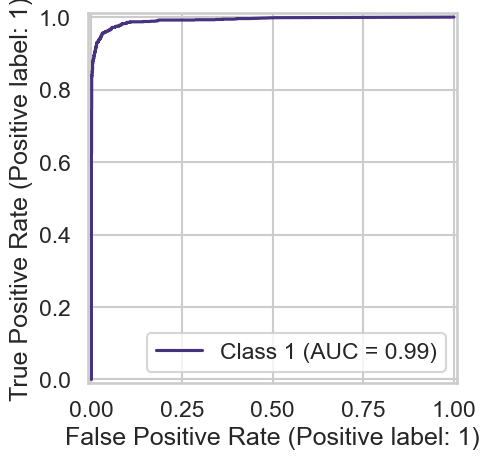

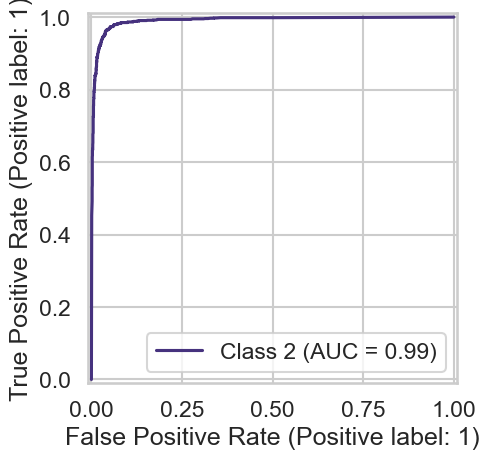

In [12]:
"""
PHASE 6 — Champion Model Selection & Deployment Bundle
Picks best model, evaluates, and saves with metadata + plots + reports.
"""

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, RocCurveDisplay
)
import json
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import logging

# --- Select Champion ---
champion_name = val_df.iloc[0]["Model"]
champion_model = tuned_models[champion_name]

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", champion_model)
])

ts = datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
bundle_dir = MODELS_DIR / f"deployment_{champion_name}_{ts}"
(bundle_dir / "plots").mkdir(parents=True, exist_ok=True)
(bundle_dir / "reports").mkdir(parents=True, exist_ok=True)

# Save final pipeline (preprocessing + model)
joblib.dump(final_pipeline, bundle_dir / "final_pipeline.joblib")

# --- Helper: Convert numpy to python native types ---
def convert(o):
    if hasattr(o, "item"):
        return o.item()
    elif isinstance(o, (list, tuple, set)):
        return [convert(i) for i in o]
    elif isinstance(o, dict):
        return {str(k): convert(v) for k, v in o.items()}
    return o

# --- Evaluate Champion ---
y_val_pred = champion_model.predict(X_val_p)

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y_val))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title(f"Confusion Matrix — {champion_name}")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
cm_path = bundle_dir / "plots" / "confusion_matrix.png"
plt.savefig(cm_path, dpi=150)
plt.close()

# Classification Report
cls_report = classification_report(y_val, y_val_pred, output_dict=True)
with open(bundle_dir / "reports" / "classification_report.json", "w", encoding="utf-8") as f:
    json.dump(convert(cls_report), f, indent=2)

pd.DataFrame(cls_report).transpose().to_csv(bundle_dir / "reports" / "classification_report.csv")

# ROC-AUC Curve (if >2 classes, compute OvR)
try:
    if hasattr(champion_model, "predict_proba"):
        y_val_proba = champion_model.predict_proba(X_val_p)
        if len(np.unique(y_val)) == 2:
            RocCurveDisplay.from_predictions(y_val, y_val_proba[:,1])
        else:
            for i, cls in enumerate(np.unique(y_val)):
                RocCurveDisplay.from_predictions(
                    (y_val == cls).astype(int), y_val_proba[:,i], name=f"Class {cls}"
                )
        plt.title(f"ROC Curve — {champion_name}")
        plt.tight_layout()
        plt.savefig(bundle_dir / "plots" / "roc_curve.png", dpi=150)
        plt.close()
except Exception as e:
    logging.warning("ROC-AUC skipped: %s", e)

# --- Save metadata artifacts ---
artifacts = {
    "champion_model": str(champion_name),
    "best_params": convert(val_df.iloc[0]["Best_Params"]),
    "feature_order": list(map(str, X.columns)),
    "class_names": {int(i): f"Stage {int(i)}" for i in sorted(y.unique())},
    "packaged_utc": ts,
    "confusion_matrix_path": str(cm_path),
    "classification_report": {
        "json": "reports/classification_report.json",
        "csv": "reports/classification_report.csv"
    },
    "roc_curve": "plots/roc_curve.png" if (bundle_dir / "plots" / "roc_curve.png").exists() else None
}
with open(bundle_dir / "artifacts.json", "w", encoding="utf-8") as f:
    json.dump(artifacts, f, indent=2)

logging.info("🏆 Champion model = %s", champion_name)
logging.info("📦 Bundle saved -> %s", bundle_dir)
logging.info("📊 Confusion matrix, classification report, ROC curve saved")
